In [10]:
import os
import pickle
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import animation as animlib
import seaborn
from collections import namedtuple

In [11]:
model = os.path.join('pretrained/models', 'model-29')
style = None
bias = 1
force = False
animation = True
noinfo = True
save = None

In [12]:
def sample(e, u1, u2, std1, std2, rho):
    conv = np.array([[std1 * std1, std1 * std2 * rho],
                     [std1 * std2 * rho, std2 * std2]])
    mean = np.array([u1, u2])
    x, y = np.random.multivariate_normal(mean, conv)
    end = np.random.binomial(1, e)
    return np.array([x, y, end])

In [13]:
def cumsum(points):
    sums = np.cumsum(points[:, :2], axis=0)
    return np.concatenate([sums, points[:, 2:]], axis=1)

In [14]:
def split_strokes(stroke_pts):
    stroke_pts = np.array(stroke_pts)
    strokes = []
    b = 0
    for i in range(len(stroke_pts)):
        if stroke_pts[i, 2] == 1:
            strokes.append(stroke_pts[b:i+1, :2])
            b = i + 1
    return strokes

In [15]:
def text_sampling(sess, args_text, translation, style = None):
    fields = ['coordinates', 'sequence', 'bias', 'e', 'pi', 'mu1', 'mu2', 'std1', 'std2',
              'rho', 'window', 'kappa', 'phi', 'finish', 'zero_states']
    fields_data = namedtuple('Params', fields)(
        *[tf.get_collection(name)[0] for name in fields]
    )
    text = np.array([translation.get(c, 0) for c in args_text])
    coord = np.array([0., 0., 1.])
    coords = [coord]
    
    print_len, style_len = 0, 0
    
    # one hot seq
    sequence = np.eye(len(translation), dtype=np.float32)[text]
    # add last column
    sequence = np.expand_dims(np.concatenate([sequence, np.zeros((1, len(translation)))]), axis=0)
    
    phi_data, window_data, kappa_data, stroke_data = [], [], [], []
    sess.run(fields_data.zero_states)
    
    for s in range(60 * len(text) + 1):
        e, pi, u1, u2, std1, std2, rho, \
        finish, phi, window, kappa = sess.run([fields_data.e, fields_data.pi, fields_data.mu1, fields_data.mu2,
                                               fields_data.std1, fields_data.std2, fields_data.rho, fields_data.finish,
                                               fields_data.phi, fields_data.window, fields_data.kappa],
                                              feed_dict={
                                                  fields_data.coordinates: coord[None, None, ...],
                                                  fields_data.sequence: sequence,
                                                  fields_data.bias: bias
                                              })
        phi_data += [phi[0, :]]
        window_data += [window[0, :]]
        kappa_data += [kappa[0, :]]
        # ---
        g = np.random.choice(np.arange(pi.shape[1]), p=pi[0])
        coord = sample(e[0, 0], u1[0, g], u2[0, g],
                       std1[0, g], std2[0, g], rho[0, g])
        coords += [coord]
        stroke_data += [[u1[0, g], u2[0, g], std1[0, g], std2[0, g], rho[0, g], coord[2]]]

        if not force and finish[0, 0] > 0.8:
            break
    
    coords = np.array(coords)
    # end of sentence
    coords[-1, 2] = 1.

    return phi_data, window_data, kappa_data, stroke_data, coords

INFO:tensorflow:Restoring parameters from pretrained/models\model-29
What to write: Hello there, wassup ?


Traceback (most recent call last):
  File "c:\users\amarjeet\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "c:\users\amarjeet\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "c:\users\amarjeet\appdata\local\programs\python\python36\lib\site-packages\matplotlib\animation.py", line 1499, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


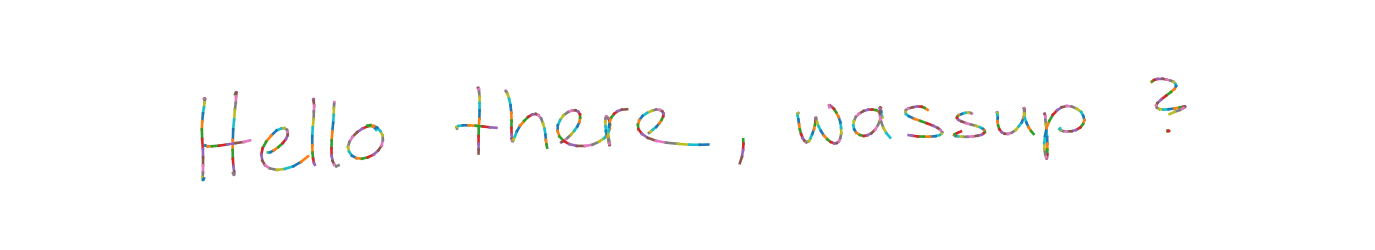

In [16]:
# load the translation file
with open(os.path.join('data_parsed', 'translation.pkl'), 'rb') as file:
    translation = pickle.load(file)

# dictionary that maps the numbers to the letters
rev_translation = {v: k for k, v in translation.items()}

# create a set of all the appeared characters
charset = [rev_translation[i] for i in range(len(rev_translation))]
charset[0] = ''

# GPU
config = tf.ConfigProto(
    device_count={'GPU': 0}
)

# tf session
with tf.Session(config=config) as sess:
    # import model
    saver = tf.train.import_meta_graph(model + '.meta')
    saver.restore(sess, model)

    while True:
        
        args_text = input('What to write: ')
        
        # sample the text, get the results
        phi_data, window_data, kappa_data, stroke_data, coords = text_sampling(sess, args_text, translation, style)
        
        # get the stroke data
        strokes = np.array(stroke_data)
        epsilon = 1e-8
        
        # to get the sequence of coordinates, as we trained the model on differences between points
        strokes[:, :2] = np.cumsum(strokes[:, :2], axis=0)
        minx, maxx = np.min(strokes[:, 0]), np.max(strokes[:, 0])
        miny, maxy = np.min(strokes[:, 1]), np.max(strokes[:, 1])
        
        # animation
        if animation:
            %matplotlib nbagg
            fig, ax = plt.subplots(1, 1, frameon=False, figsize=(11, 2))
            ax.set_xlim(minx - 1., maxx + 1.)
            ax.set_ylim(-maxy - 0.5, -miny + 0.5)
            ax.set_aspect('equal')
            ax.axis('off')
            # ax.hold(True)

            plt.draw()
            plt.show(False)

            background = fig.canvas.copy_from_bbox(ax.bbox)

            sumed = cumsum(coords)

            def _update(i):
                c1, c2 = sumed[i: i+2]
                fig.canvas.restore_region(background)
                if c1[2] == 1. and c2[2] == 1.:
                    line, = ax.plot([c2[0], c2[0]], [-c2[1], -c2[1]])
                elif c1[2] != 1.:
                    line, = ax.plot([c1[0], c2[0]], [-c1[1], -c2[1]])
                else:
                    line, = ax.plot([c1[0], c1[0]], [-c1[1], -c1[1]])
                fig.canvas.blit(ax.bbox)
                return line,

            anim = animlib.FuncAnimation(fig, _update, frames=len(sumed) - 2,
                                           interval=16, blit=True, repeat=False)
            if save is not None:
                save(save, fps=60, extra_args=['-vcodec', 'libx264'])
            plt.show()
        else:
            fig, ax = plt.subplots(1, 1)
            for stroke in split_strokes(cumsum(np.array(coords))):
                # negative Y otherwise the output comes flipped
                plt.plot(stroke[:, 0], -stroke[:, 1])
            ax.set_title('Handwriting')
            ax.set_aspect('equal')
            plt.show()
        
        if args_text is not None:
            break